### Setting up environment

In [1]:
!pip install -U sentence-transformers faiss-cpu datasets rank_bm25 transformers accelerate

In [2]:
import random
import numpy as np
import torch

def set_seed(seed=67):
    """Set the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(67)

In [3]:
import json
import nltk
nltk.download("stopwords")

# CONFIGURATION
CONFIG = {
    "seed": 67,
    "model_name": "sentence-transformers/all-MiniLM-L6-v2",
    "dataset_name": "ms_marco",
    "dataset_subset": "v1.1",
    "dataset_size": 50000,
    "train_samples": 10000,
    "batch_size": 32,
    "num_epochs": 1,
    "hybrid_alpha": 0.5,
    "top_k": 10,
    "bm25_k1": 1.2,
    "bm25_b": 0.3,
    "w_dense": 1.0,
    "w_sparse": 0.3
}

with open("config.json", "w") as f:
    json.dump(CONFIG, f, indent=4)

print("config.json created successfully.")

# SETTING VARS FROM CONFIG
DATASET_SIZE = CONFIG["dataset_size"]
MODEL_NAME = CONFIG["model_name"]
NUM_TRAIN_SAMPLES = CONFIG["train_samples"]
TRAIN_BATCH_SIZE = CONFIG["batch_size"]
NUM_EPOCHS = CONFIG["num_epochs"]
BM25_K1 = CONFIG["bm25_k1"]
BM25_B = CONFIG["bm25_b"]
W_DENSE = CONFIG["w_dense"]
W_SPARSE = CONFIG["w_sparse"]

config.json created successfully.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data and Embedding Baseline

### Loading the Dataset and Model

To begin, we load the Dataset and Model

In [4]:
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import time

print("Loading MS MARCO dataset")
dataset_stream = load_dataset('ms_marco', 'v1.1', split='train', streaming=True)

corpus = []
corpus_ids = []
counter = 0

print("Extracting passages")
for row in dataset_stream:
    passages = row['passages']['passage_text']

    for p in passages:
        corpus.append(p)
        corpus_ids.append(counter)
        counter += 1

        if counter >= DATASET_SIZE:
            break
    if counter >= DATASET_SIZE:
        break

print(f"Successfully loaded {len(corpus)} documents.")
print(f"\nLoading Model: {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME)
print("Model loaded successfully.")

Loading MS MARCO dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting passages
Successfully loaded 50000 documents.

Loading Model: sentence-transformers/all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded successfully.


### Encoding

Then we encode the doccuments from the dataset and build the FAISS index

In [5]:
import faiss
import numpy as np

print("Encoding documents")
start_time = time.time()

# We use batch_size=64 to speed up processing on the GPU
corpus_embeddings = model.encode(corpus, batch_size=64, show_progress_bar=True, convert_to_numpy=True)

# Normalize vectors
faiss.normalize_L2(corpus_embeddings)

print(f"Encoding finished in {time.time() - start_time:.2f} seconds.")

# BUILD FAISS INDEX
print("\nBuilding FAISS Index")
d = corpus_embeddings.shape[1]

index = faiss.IndexFlatIP(d)
index.add(corpus_embeddings)

print(f"Index ready. Total documents indexed: {index.ntotal}")

Encoding documents


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Encoding finished in 69.54 seconds.

Building FAISS Index
Index ready. Total documents indexed: 50000


### Testing the Baseline

Testing the baseline model

In [6]:
def search(query, top_k=5):
    print(f"\nSearch Query: '{query}'")

    # Encode the query
    query_embedding = model.encode([query], convert_to_numpy=True)

    # Normalize
    faiss.normalize_L2(query_embedding)

    # Search FAISS
    distances, indices = index.search(query_embedding, top_k)

    # Print results
    print(f"--- Top {top_k} Results ---")
    for rank, (score, idx) in enumerate(zip(distances[0], indices[0])):
        print(f"[Rank {rank+1}] Score: {score:.4f}")
        print(f"Text: {corpus[idx]}")
        print("-" * 50)
search("what is the capital of australia") # We can try searching different stuff here


Search Query: 'what is the capital of australia'
--- Top 5 Results ---
[Rank 1] Score: 0.6442
Text: Australia is a developed country and one of the wealthiest in the world, with the world's 12th-largest economy. In 2014 Australia had the world's fifth-highest per capita income. Australia's military expenditure is the world's 13th-largest. Australia (/ɒˈstreɪliə/ , /ə-/ , colloquially /-jə/), officially the Commonwealth of Australia, is an Oceanian country comprising the mainland of the Australian continent, the island of Tasmania, and numerous smaller islands.
--------------------------------------------------
[Rank 2] Score: 0.6301
Text: Sydney is the capital city of the Australian state of New South Wales, and Australia's largest city. A week in Sydney will help you see many of the sights of Sydney and its surrounds, and understand the city and its culture. If you're up for exploring the area by bike (one of the best ways to do so as much of it is parkland), take the train to Concor

# Fine-tuning

### Hard Negatives and MRL

In this section we fine tune the model using Hard Negatives and Matryoshka Representation Learning

In [7]:
from torch.utils.data import DataLoader
from sentence_transformers import InputExample, losses
import random

# We define the dimensions we want the model to be good at
MATRYOSHKA_DIMS = [384, 192, 96, 64]

train_stream = load_dataset('ms_marco', 'v1.1', split='train', streaming=True)
train_examples = []
count = 0

# Mining Negatives
# We skip the top 5 results to avoid accidental False Negatives
print("Mining Hard Negatives")
for row in train_stream:
    q = row['query']
    try:
        pos_idx = row['passages']['is_selected'].index(1)
        pos_txt = row['passages']['passage_text'][pos_idx]
    except: continue

    q_vec = model.encode([q], convert_to_numpy=True)
    faiss.normalize_L2(q_vec)

    # Search deeper (Top 50)
    _, idxs = index.search(q_vec, k=50)

    # Randomly select a negative from Rank 5-50
    # Rank 1-4 are often "correct but unlabeled", so we avoid them
    safe_neg_idx = idxs[0][random.randint(5, 49)]
    neg_txt = corpus[safe_neg_idx]

    if neg_txt != pos_txt:
        train_examples.append(InputExample(texts=[q, pos_txt, neg_txt]))
        count += 1

    if count >= 10000: break

print(f"Mined {len(train_examples)} triplets.")

# Setup Matryoshka Loss
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=TRAIN_BATCH_SIZE)
inner_loss = losses.MultipleNegativesRankingLoss(model)
train_loss = losses.MatryoshkaLoss(
    model=model,
    loss=inner_loss,
    matryoshka_dims=MATRYOSHKA_DIMS
)

# Train
print("Starting Training (MRL)")
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    optimizer_params={'lr': 2e-5}, # Low LR is safe
    show_progress_bar=True
)
print("Fine-Tuning Complete.")

Mining Hard Negatives
Mined 10000 triplets.
Starting Training (MRL)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Fine-Tuning Complete.


### Re-encoding

Because the model weights changed we need to re-encode the corpus

In [8]:
import faiss
import numpy as np

new_corpus_embeddings = model.encode(corpus, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
faiss.normalize_L2(new_corpus_embeddings)

d = new_corpus_embeddings.shape[1]
index = faiss.IndexFlatIP(d)
index.add(new_corpus_embeddings)

print(f"New Index Ready. Total documents: {index.ntotal}")

search("what is the capital of australia") # Trying search now

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

New Index Ready. Total documents: 50000

Search Query: 'what is the capital of australia'
--- Top 5 Results ---
[Rank 1] Score: 0.6536
Text: Australia is a developed country and one of the wealthiest in the world, with the world's 12th-largest economy. In 2014 Australia had the world's fifth-highest per capita income. Australia's military expenditure is the world's 13th-largest. Australia (/ɒˈstreɪliə/ , /ə-/ , colloquially /-jə/), officially the Commonwealth of Australia, is an Oceanian country comprising the mainland of the Australian continent, the island of Tasmania, and numerous smaller islands.
--------------------------------------------------
[Rank 2] Score: 0.6413
Text: Sydney is the capital city of the Australian state of New South Wales, and Australia's largest city. A week in Sydney will help you see many of the sights of Sydney and its surrounds, and understand the city and its culture. If you're up for exploring the area by bike (one of the best ways to do so as much of i

# Hybrid System

To begin with, we need to build the BM25 index for the Hybrid model (Dense + BM25)

In [9]:
from rank_bm25 import BM25Okapi
import string
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

# Simple tokenizer
def tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

# Tokenize the entire corpus
tokenized_corpus = [tokenize(doc) for doc in corpus]

# Build BM25 Object
bm25 = BM25Okapi(tokenized_corpus, k1=BM25_K1, b=BM25_B)

print(f"BM25 Index Ready for {len(tokenized_corpus)} documents.")

BM25 Index Ready for 50000 documents.


In [10]:
def hybrid_search(query, top_k=10, k_rrf=60, w_dense=1.0, w_sparse=0.3):
    # Dense candidates
    q_vec = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_vec)
    _, d_indices = index.search(q_vec, k=100)

    # Sparse candidates
    tokenized_query = tokenize(query)
    bm25_scores = bm25.get_scores(tokenized_query)
    s_indices = np.argsort(bm25_scores)[-100:][::-1]

    fusion_scores = {}

    # Dense RRF
    for rank, idx in enumerate(d_indices[0]):
        fusion_scores.setdefault(idx, 0.0)
        fusion_scores[idx] += w_dense * (1.0 / (k_rrf + rank + 1))

    # BM25 RRF
    for rank, idx in enumerate(s_indices):
        fusion_scores.setdefault(idx, 0.0)
        fusion_scores[idx] += w_sparse * (1.0 / (k_rrf + rank + 1))

    results = sorted(fusion_scores.items(), key=lambda x: x[1], reverse=True)
    return results[:top_k]

# Evaluation & Metrics

### Cross encoding and Re-ranking

To improve performance, we try cross-encoding and re-ranking

In [11]:
from sentence_transformers import CrossEncoder

print("Loading Cross-Encoder")
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def search_with_rerank(query, top_k=10, initial_k=50):
    # Retrieving
    q_vec = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_vec)
    _, idxs = index.search(q_vec, k=initial_k)

    candidate_indices = idxs[0]
    candidate_docs = [corpus[i] for i in candidate_indices]

    # Re-Ranking
    # Prepare pairs for the Cross-Encoder: [(Query, Doc1), (Query, Doc2)]
    pairs = [[query, doc] for doc in candidate_docs]

    # Get scores
    cross_scores = cross_encoder.predict(pairs)

    # Sort by Cross-Encoder Score
    # Combine indices with new scores
    reranked_results = sorted(
        zip(candidate_indices, cross_scores),
        key=lambda x: x[1],
        reverse=True
    )

    return reranked_results[:top_k]

Loading Cross-Encoder


Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: cross-encoder/ms-marco-MiniLM-L-6-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


### Evaluation

This is the Main Evaluation Cell for our models

In [17]:
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss
from datasets import load_dataset

CUTOFFS = [1, 5, 10, 20]
MAX_K = 20

def calculate_metrics(retrieved_docs, correct_text):
    try:
        rank = retrieved_docs.index(correct_text) + 1
    except ValueError:
        rank = float('inf')

    # MRR
    mrr = 1.0 / rank if rank <= MAX_K else 0.0
    metrics = [mrr]

    # Recall@k
    for k in CUTOFFS:
        recall = 1.0 if rank <= k else 0.0
        metrics.append(recall)

    # NDCG@k
    for k in CUTOFFS:
        if rank <= k:
            ndcg = 1.0 / np.log2(rank + 1)
        else:
            ndcg = 0.0
        metrics.append(ndcg)

    # Precision@k
    for k in CUTOFFS:
        precision = (1.0 / k) if rank <= k else 0.0
        metrics.append(precision)

    return metrics

# Evaluating Baseline
base_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
base_embeddings = base_model.encode(
    corpus, batch_size=64, convert_to_numpy=True, show_progress_bar=False
)
faiss.normalize_L2(base_embeddings)
base_index = faiss.IndexFlatIP(base_embeddings.shape[1])
base_index.add(base_embeddings)

# Setting up dataset for evaluation
val_stream = load_dataset('ms_marco', 'v1.1', split='validation', streaming=True)
test_queries = []
for row in val_stream:
    if len(test_queries) >= 100: # 100 Queries
        break
    try:
        pos_idx = row['passages']['is_selected'].index(1)
        correct_text = row['passages']['passage_text'][pos_idx]
        if correct_text in corpus:
            test_queries.append((row['query'], correct_text))
    except Exception:
        continue

print(f"Collected {len(test_queries)} valid test queries.")

# Running evaluation
results = {"Baseline": [], "Fine-Tuned": [], "Hybrid": [], "Re-Ranker": []}
print("Running Evaluation Loops")

for query, correct_text in test_queries:
    # BASELINE
    q_vec = base_model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_vec)
    _, idxs = base_index.search(q_vec, k=10)
    base_docs = [corpus[i] for i in idxs[0]]
    results["Baseline"].append(calculate_metrics(base_docs, correct_text))

    # FINE-TUNED
    q_vec_ft = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_vec_ft)
    _, idxs_ft = index.search(q_vec_ft, k=10)
    ft_docs = [corpus[i] for i in idxs_ft[0]]
    results["Fine-Tuned"].append(calculate_metrics(ft_docs, correct_text))

    # C. HYBRID SEARCH
    rrf_results = hybrid_search(query, top_k=10, w_dense=W_DENSE, w_sparse=W_SPARSE)
    hyb_docs = [corpus[idx] for idx, _ in rrf_results]
    results["Hybrid"].append(calculate_metrics(hyb_docs, correct_text))

    # D. RE-RANKER (Evaluating dense after cross encoding and reranking)
    rr_results = search_with_rerank(query, top_k=10, initial_k=50)
    rr_docs = [corpus[idx] for idx, _ in rr_results]
    results["Re-Ranker"].append(calculate_metrics(rr_docs, correct_text))

print("\n" + "=" * 140)
header = f"{'SYSTEM':<15} | {'MRR':<8} | "
header += " | ".join([f"R@{k:<2}" for k in CUTOFFS]) + " | "
header += " | ".join([f"N@{k:<2}" for k in CUTOFFS]) + " | "
header += " | ".join([f"P@{k:<2}" for k in CUTOFFS])
print(header)
print("-" * 140)

for sys_name in ["Baseline", "Fine-Tuned", "Hybrid", "Re-Ranker"]:
    if not results[sys_name]: continue

    scores = np.array(results[sys_name])
    means = np.mean(scores, axis=0)
    row_str = f"{sys_name:<15} | {means[0]:.4f}   | "
    row_str += " | ".join([f"{x:.4f}" for x in means[1:5]]) + " | "
    row_str += " | ".join([f"{x:.4f}" for x in means[5:9]]) + " | "
    row_str += " | ".join([f"{x:.4f}" for x in means[9:13]])
    print(row_str)

print("=" * 140)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Collected 100 valid test queries.
Running Evaluation Loops

SYSTEM          | MRR      | R@1  | R@5  | R@10 | R@20 | N@1  | N@5  | N@10 | N@20 | P@1  | P@5  | P@10 | P@20
--------------------------------------------------------------------------------------------------------------------------------------------
Baseline        | 0.4270   | 0.2500 | 0.6400 | 0.8700 | 0.8700 | 0.2500 | 0.4571 | 0.5317 | 0.5317 | 0.2500 | 0.1280 | 0.0870 | 0.0435
Fine-Tuned      | 0.4296   | 0.2600 | 0.6600 | 0.8500 | 0.8500 | 0.2600 | 0.4680 | 0.5292 | 0.5292 | 0.2600 | 0.1320 | 0.0850 | 0.0425
Hybrid          | 0.4050   | 0.2500 | 0.6200 | 0.8000 | 0.8000 | 0.2500 | 0.4403 | 0.4984 | 0.4984 | 0.2500 | 0.1240 | 0.0800 | 0.0400
Re-Ranker       | 0.5261   | 0.3500 | 0.8000 | 0.9200 | 0.9200 | 0.3500 | 0.5812 | 0.6209 | 0.6209 | 0.3500 | 0.1600 | 0.0920 | 0.0460


### Latency, Memory Usage and Scalability

Finally measuring Latency and Memory Usage

In [13]:
import time
import numpy as np
import sys

# Latency
test_queries = list(val_queries.values())[:100] if 'val_queries' in locals() else ["symptoms of flu", "capital of france", "python tutorial"] * 33
latencies = []
for q in test_queries:
    start = time.time()
    if 'search_with_rerank' in locals():
        search_with_rerank(q, top_k=5)
    elif 'hybrid_search' in locals():
        hybrid_search(q, top_k=5)
    else:
        pass
    end = time.time()
    latencies.append((end - start) * 1000)
p95 = np.percentile(latencies, 95)
p50 = np.percentile(latencies, 50)
print("\n" + "="*30)
print(f" Latency (p95): {p95:.2f} ms")
print(f" Latency (p50): {p50:.2f} ms")

# Memory Usage
dense_index_size = index.ntotal * index.d * 4 / (1024**2)
bm25_size = sum(len(s) for s in tokenized_corpus) * 4 / (1024**2)
print(f"Dense Index Memory: ~{dense_index_size:.2f} MB")
print(f"BM25 Index Memory:  ~{bm25_size:.2f} MB")
print(f"Total System Memory: ~{dense_index_size + bm25_size:.2f} MB")


 Latency (p95): 115.24 ms
 Latency (p50): 87.32 ms
Dense Index Memory: ~73.24 MB
BM25 Index Memory:  ~7.58 MB
Total System Memory: ~80.82 MB


   Indexed 1000 docs -> 0.084 ms / query
   Indexed 5000 docs -> 0.407 ms / query
   Indexed 10000 docs -> 0.765 ms / query
   Indexed 25000 docs -> 2.778 ms / query
   Indexed 50000 docs -> 6.715 ms / query


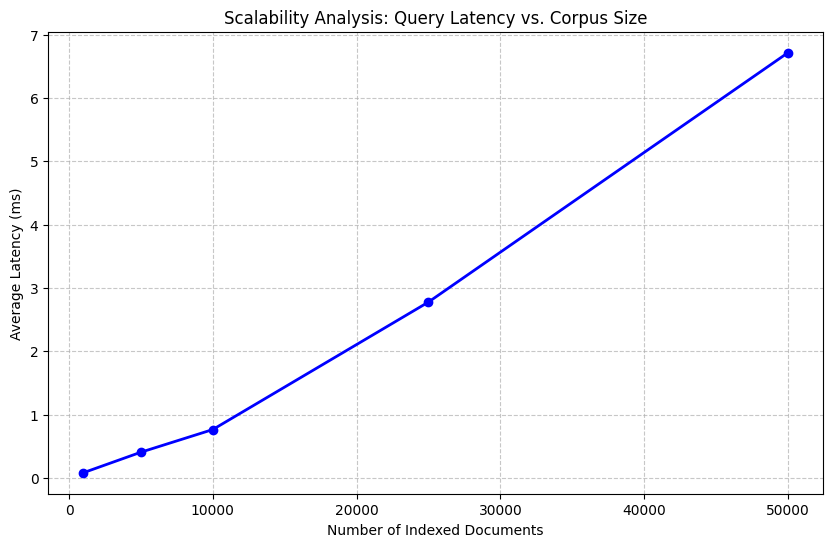

In [18]:
import time
import numpy as np
import faiss
import matplotlib.pyplot as plt

subset_sizes = [1000, 5000, 10000, 25000, 50000]
latencies = []

q_vec = model.encode(["test query"], convert_to_numpy=True)
faiss.normalize_L2(q_vec)

for size in subset_sizes:
    if size > len(corpus_embeddings):
        break

    subset_emb = corpus_embeddings[:size]
    d = subset_emb.shape[1]
    temp_index = faiss.IndexFlatIP(d)
    temp_index.add(subset_emb)

    start_time = time.time()
    for _ in range(100):
        temp_index.search(q_vec, k=10)
    end_time = time.time()

    avg_ms = ((end_time - start_time) / 100) * 1000
    latencies.append(avg_ms)
    print(f"   Indexed {size} docs -> {avg_ms:.3f} ms / query")

plt.figure(figsize=(10, 6))
plt.plot(subset_sizes[:len(latencies)], latencies, marker='o', linestyle='-', color='b', linewidth=2)
plt.title('Scalability Analysis: Query Latency vs. Corpus Size')
plt.xlabel('Number of Indexed Documents')
plt.ylabel('Average Latency (ms)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

For scaling this further the FAISS IndexFlat IP scales linearly O(N), for >1M doccuments we can switch to FAISS IVF-PQ to maintain decent latency.

# Streamlit API

Saving artifacts for streamlit

In [14]:
import pickle
import faiss

with open("corpus.pkl", "wb") as f:
    pickle.dump(corpus, f)

faiss.write_index(index, "semantic_search.index")

with open("config.pkl", "wb") as f:
    pickle.dump({"model_name": "sentence-transformers/all-MiniLM-L6-v2"}, f)


In [15]:
%%writefile app.py
import streamlit as st
import faiss
import pickle
import numpy as np
from sentence_transformers import SentenceTransformer, CrossEncoder

st.set_page_config(page_title="DeepSearch Engine", page_icon="👅", layout="wide")

@st.cache_resource
def load_resources():
    print("Loading resources...")
    with open("corpus.pkl", "rb") as f:
        corpus = pickle.load(f)

    index = faiss.read_index("semantic_search.index")

    bi_encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

    return corpus, index, bi_encoder, cross_encoder

corpus, index, bi_encoder, cross_encoder = load_resources()

def dense_search(query, k=50):
    q_vec = bi_encoder.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_vec)
    _, idxs = index.search(q_vec, k)
    return [corpus[i] for i in idxs[0]]

def rerank_search(query, top_k=10):
    candidates = dense_search(query, k=50)

    pairs = [[query, doc] for doc in candidates]
    scores = cross_encoder.predict(pairs)

    results = sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)
    return results[:top_k]

st.title("Deep Semantic Search")
st.markdown("""
This system uses a **Bi-Encoder** for fast retrieval and a **Cross-Encoder** for high-precision re-ranking.
""")

with st.sidebar:
    st.header("Settings")
    top_k = st.slider("Results to Show", 1, 20, 5)
    use_reranker = st.checkbox("Enable Re-Ranker", value=True)
    st.info("Re-ranker is slower (~200ms) but much more accurate.")

query = st.text_input("Enter your search query:", placeholder="e.g., symptoms of flu")

if query:
    with st.spinner("Searching database..."):
        if use_reranker:
            results = rerank_search(query, top_k=top_k)
        else:
            docs = dense_search(query, k=top_k)
            results = [(d, 0.0) for d in docs]

    st.success(f"Found {len(results)} relevant results")

    for rank, (text, score) in enumerate(results):
        with st.container():
            col1, col2 = st.columns([1, 15])
            with col1:
                st.markdown(f"### #{rank+1}")
            with col2:
                if use_reranker:
                    st.caption(f"Relevance Score: **{score:.4f}**")
                st.markdown(f"**{text}**")
            st.divider()

Overwriting app.py


In [16]:
!pip install -q streamlit pyngrok
!ngrok authtoken 39DF2MT0PtKknk7X502QCwwW6Ta_6br7iWmoz23K61x4B3zPH
from pyngrok import ngrok
import time

ngrok.kill()

public_url = ngrok.connect(8501).public_url
print(f"Streamlit is live at: {public_url}")

!streamlit run app.py &>/dev/null&

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit is live at: https://triangled-kelly-shoofly.ngrok-free.dev


Use the link generated in the output